<a href="https://colab.research.google.com/github/jiahas/ia905/blob/main/Ex02_195673.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nome:Chen Jiahao

RA:195673

Curso:Engenharia Elétrica Noturno


# Ex02 - Histograma e Extração de Características

Esta atividade tem 2 objetivos principais:
  - Entender o conceito de histograma e estatísticas da imagem;
  - Explorar diferentes formas de extração de características em histogramas e sua aplicação em um problema de classificação.

In [ ]:
# Importando as bibliotecas que serão utilizadas
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import seaborn as sn
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage import data
# Definindo o nome da pasta compartilhada
# IMPORTANTE: substitua "NOME_DA_PASTA_COMPARTILHADA" abaixo pelo nome correspondente
pasta_compartilhada = "P_IA905A_2024S1"

In [ ]:
# Conexão do colab com o drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Parte 1 - Histograma

Leia o notebook [Histograma de imagens](https://github.com/lrittner/Computacao-Visual/blob/master/tutoriais/05_Histograma_da_imagem.ipynb) para entender o conceito de histograma e o uso da função *np.histogram*. Tente também entender a função a seguir, que plota o histograma usando gráfico de barras. Essa função será muito útil nos exercícios deste notebook.

In [ ]:
def plota_hist(h,cor,nbins,bin_edges):

    w=255./nbins
    bin_centers = bin_edges[1:]-(w/2)
    plt.bar(bin_centers, h, width=w, color=cor)

### Exercício 1.1

Vamos tentar calcular o histograma de imagens coloridas. Para isso, utilize as imagens tiradas durante o dia ou durante a noite, disponíveis em *Dados/Ex02/Example* e apresentadas no código abaixo.

Plote os histogramas de cada uma das bandas das imagens usando gráficos de barras (função "**plota_hist**"). Compare visualmente os histogramas e comente as principais diferenças observadas. Se você tivesse que dizer quais histogramas pertencem a quais classes de imagem (dia ou noite), você seria capaz de acertar? Explique porque.

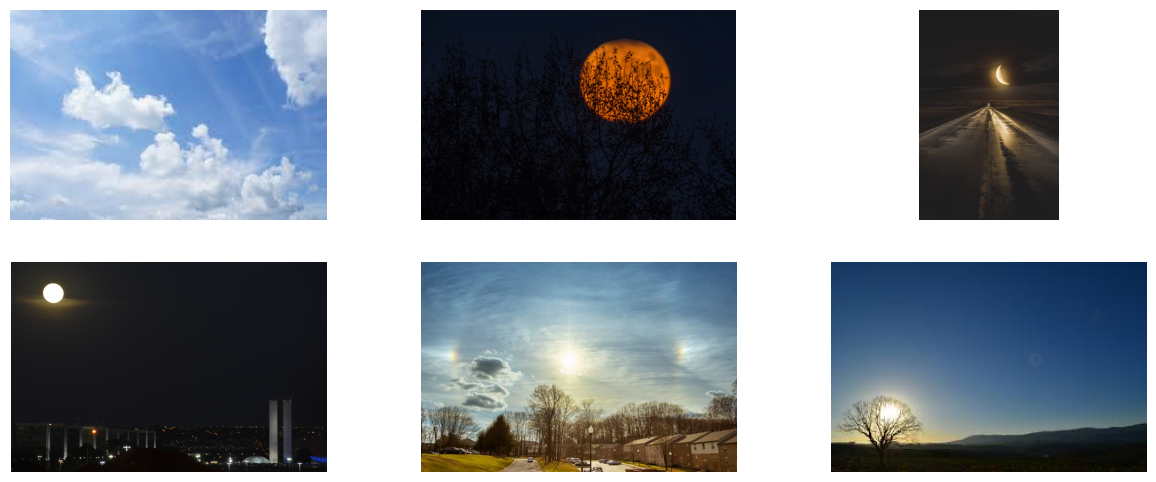

In [ ]:
path = f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex02/Example/"

fig, axs = plt.subplots(2,3,figsize=(15, 6))

list_files = os.listdir(path)
for i, file in enumerate(list_files):
  plt.subplot(2,3,1+i)
  plt.axis('off')
  img = mpimg.imread(path+file)

  plt.imshow(img)

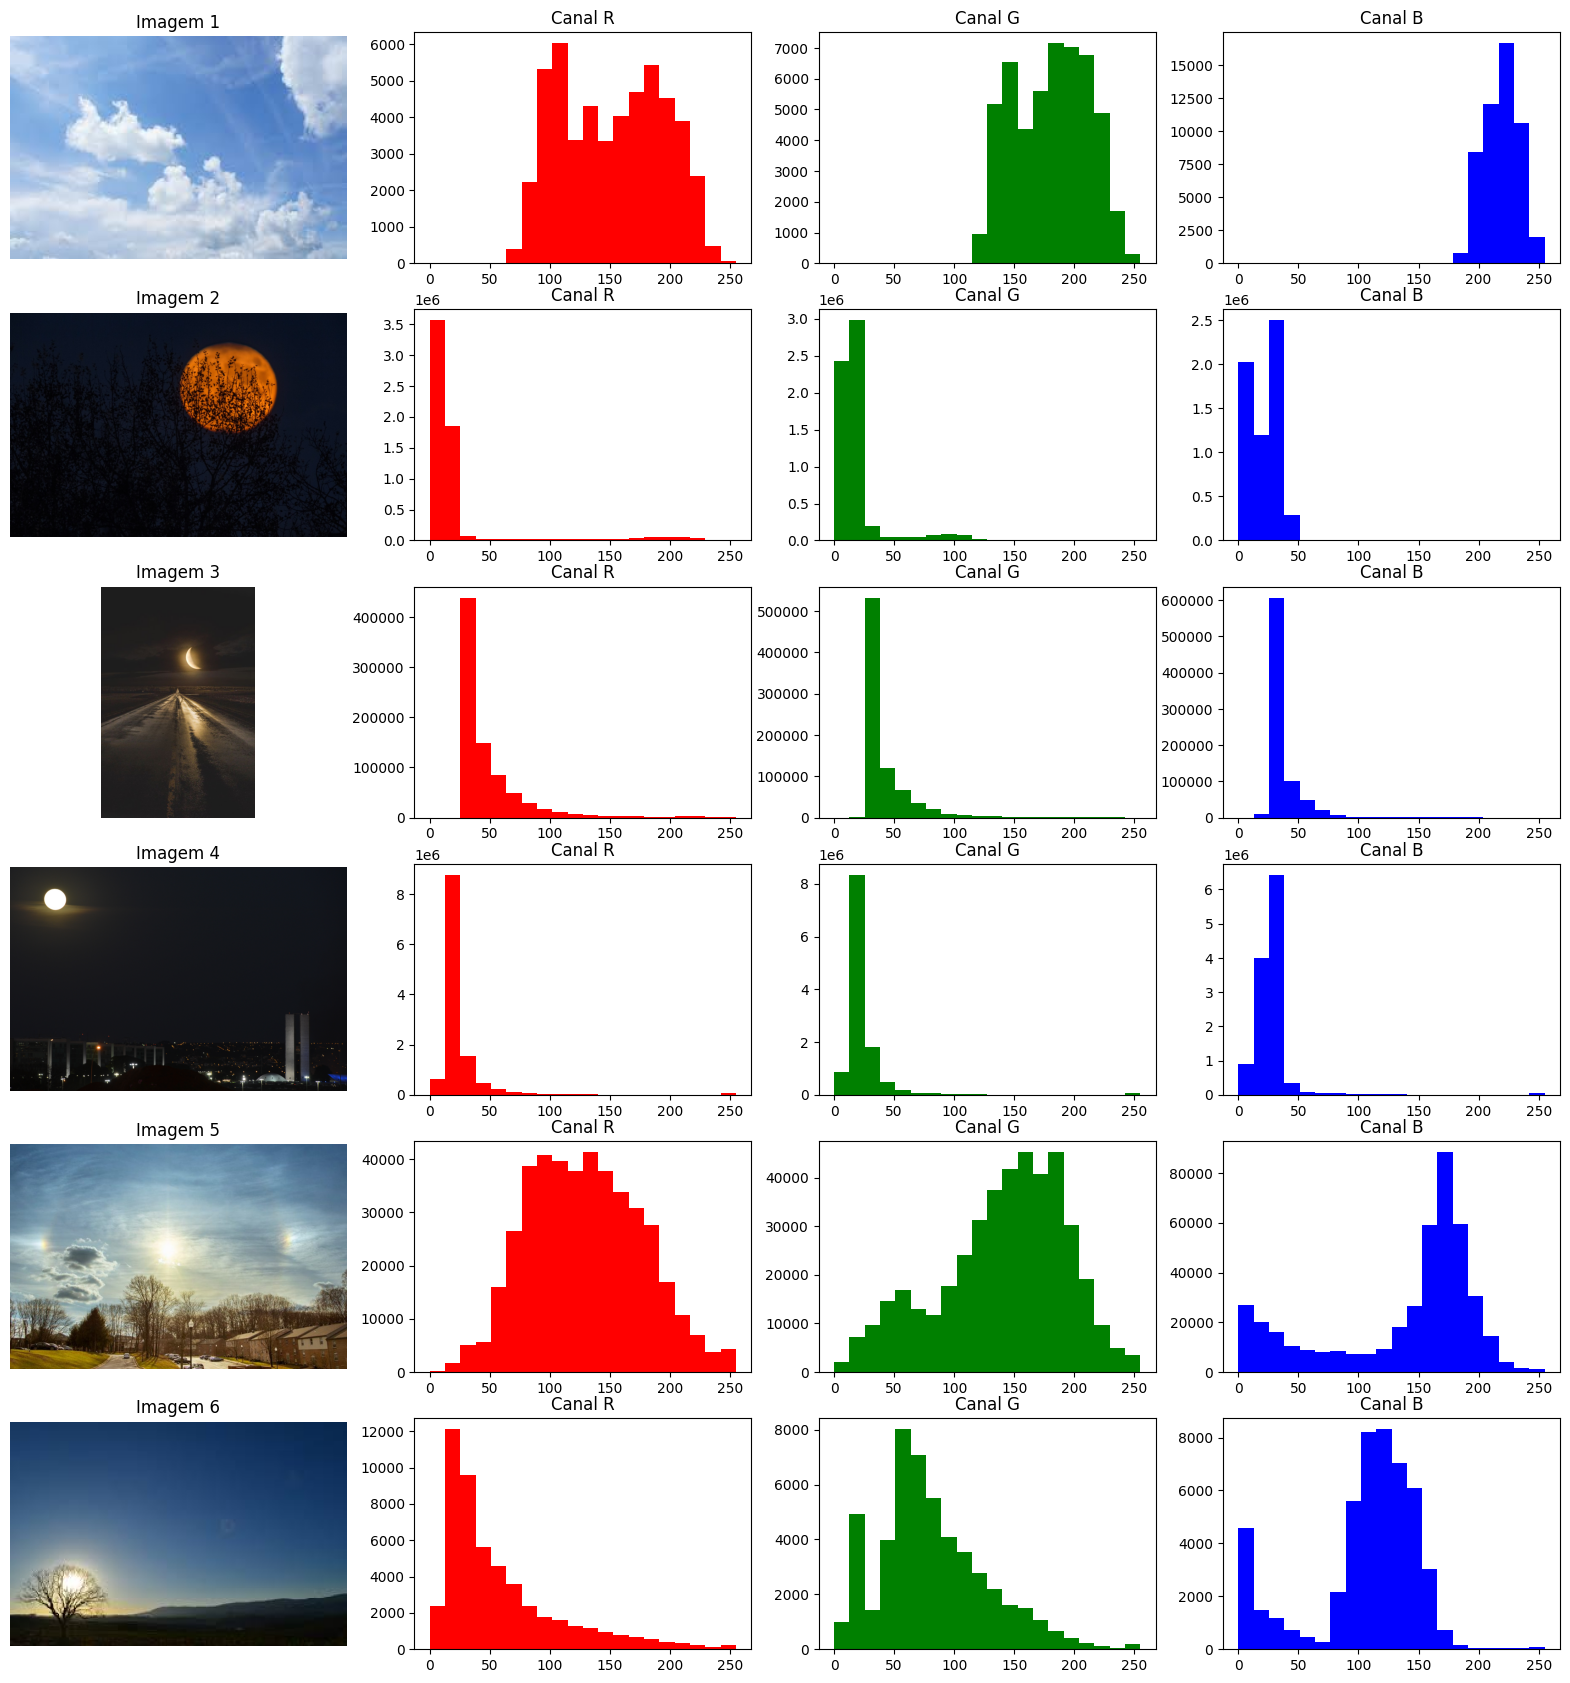

In [ ]:
fig, axs = plt.subplots(6,4,figsize=(20, 21))
nbins = 20
list_files = os.listdir(path)

# Definindo cores para plotar
colors = plt.rcParams["axes.prop_cycle"]()
c_rgb = ['r','g','b']
for i, file in enumerate(list_files):
  plt.subplot(6,4,4*i+1)
  plt.title(f'Imagem {i+1}')
  plt.axis('off')
  img = mpimg.imread(path+file)
  plt.imshow(img)
  for j, color in enumerate(c_rgb):
    plt.subplot(6,4,1+4*i+j+1)
    plt.title(f'Canal {color.upper()}')
    img = mpimg.imread(path+file)
    h, bin_edges = np.histogram(img[:,:,j], nbins,(0,255))
    plota_hist(h,color,nbins,bin_edges)

**Reposta:** Dos diagramas acima que a contagem de pixeis para os histogramas 2, 3 e 4 são muito maiores que 1, 5 e 6. O padrão dos histogramas 2, 3 e 6 remete a um padrão de imagem escura ou de noite pois a concentração de píxeis está na região próxima de 0, este padrão pode levar à um engano ao classificar o histograma 6 pois não é possível ter certeza de é de dia ou de noite.

É possível afirmar que o histograma 1 e 5 são de dia pois há maior concentração píxeis na região de maior intensidade, uma parte do padrão pode ser observado em 6.

### Exercício 1.2

Selecione duas imagens coloridas do item anterior (uma de dia e uma de noite) e faça a conversão para níveis de cinza, usando um dos métodos abaixo:
   - médias das bandas R, G, B;
   - média ponderada das bandas R, G, B: procure qual a poderação mais utilizada;
   - convert(L) da biblioteca PIL;

Em seguida, calcule o histograma das imagens convertidas para níveis de cinza. Compare os histogramas em níveis de cinza e discuta novamente as diferenças.   

In [ ]:
# NTSC formula: 0.299*Red + 0.587*Green + 0.114*Blue
def rgb_to_gray(img):
  gray = np.uint8( 0.3*img[:,:,0] + 0.59*img[:,:,1] + 0.11*img[:,:,2])
  return gray

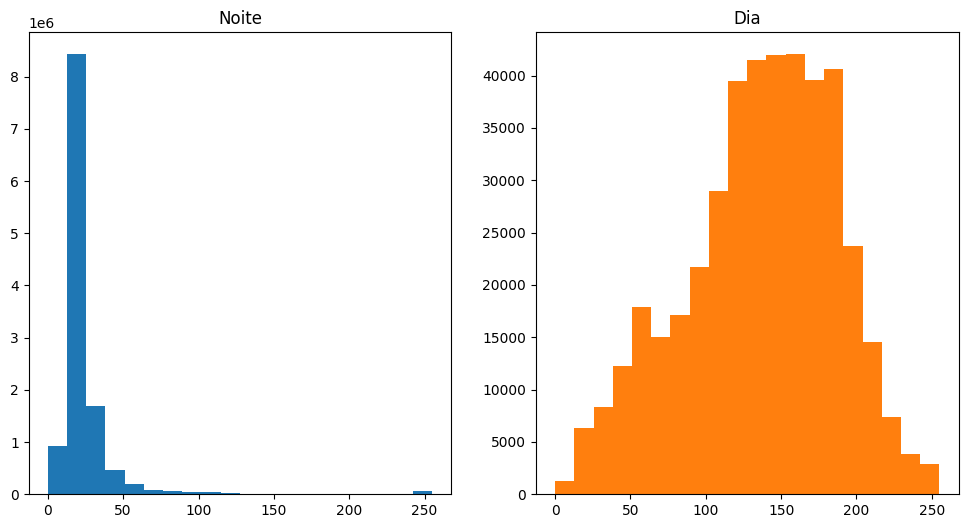

In [ ]:
noite = mpimg.imread(path+list_files[3])
dia = mpimg.imread(path+list_files[4])

imagens = {"Noite" : mpimg.imread(path+list_files[3]),
            "Dia" : mpimg.imread(path+list_files[4])}

fig, axs = plt.subplots(1,2,figsize=(12, 6))

for i, k in enumerate(imagens.keys()):
  plt.subplot(1,2,1+i)
  c = next(colors)["color"]
  imagens[k] = rgb_to_gray(imagens[k])
  h, bin_edges = np.histogram(imagens[k], nbins,(0,255))
  plota_hist(h,c,nbins,bin_edges)
  plt.title(k)


**Reposta:** Em questão de níveis de cinza, a diferença entre dia e noite é mais notável pois a concentração de píxeis de menor intensidade cai bastante na imagem de dia e na imagem de noite compõe praticamente a imagem toda.

## Parte 2 - Extraindo atributos derivados do histograma

Histogramas podem ser utilizados para extrair atributos de imagens. Estes dados são úteis em tarefas de aprendizado de máquina, como a classificação de imagens.

Dentre os atribitos mais comuns usados para a classificação de imagens, estão: *média*, *variância*, *assimetria* e *curtose*.

A função abaixo calcula, dada uma imagem em níveis de cinza, o histograma e seus atributos. Além dos atributos listados acima, ela também calcula os percentis 1, 10, 50, 90 e 99%.

In [ ]:
def histstat(f):

    h, bin_edges = np.histogram(f, 256, (0,255))
    hn = 1.0*h/h.sum() # compute the normalized image histogram
    cum_hn = np.cumsum(hn) # compute the cumulative image histogram
    v = np.zeros(9) # number of statistics

    # compute statistics
    n = len(h) # number of values
    v[0]  = np.sum((np.arange(n)*hn)) # mean
    v[1]  = np.sum(np.power((np.arange(n)-v[0]),2)*hn) # variance
    v[2]  = np.sum(np.power((np.arange(n)-v[0]),3)*hn)/(np.power(v[1],1.5)) # skewness
    v[3]  = np.sum(np.power((np.arange(n)-v[0]),4)*hn)/(np.power(v[1],2))-3 # kurtosis
    v[4] = np.where(cum_hn >= 0.01)[0][0] # 1% percentile
    v[5] = np.where(cum_hn >= 0.1)[0][0] # 10% percentile
    v[6] = np.where(cum_hn >= 0.5)[0][0] # 50% percentile
    v[7] = np.where(cum_hn >= 0.9)[0][0] # 90% percentile
    v[8] = np.where(cum_hn >= 0.99)[0][0] # 99% percentile

    return v

Se quisermos então extrair os atributos de histograma de uma das imagens tiradas durante o dia, basta fazermos:

In [ ]:
f = mpimg.imread(path+list_files[0])
f_gray = np.uint8(0.3*f[:,:,0]+0.59*f[:,:,1]+0.11*f[:,:,2]) # Conversão para níveis de cinza
hist_features = histstat(f_gray)
for feature in hist_features:
  print(f'{feature:.2f}')

175.75
1035.83
-0.03
-1.11
118.00
132.00
178.00
218.00
237.00


### Exercício 2.1

Extraia agora os atributos de uma das imagens tiradas durante a noite e compare com os atributos da imagem anterior. Eles parecem suficientemente diferentes para distinguir uma da outra?

In [ ]:
# Reutilizando o snippet anterior

f = mpimg.imread(path+list_files[1])
f_gray = np.uint8(0.3*f[:,:,0]+0.59*f[:,:,1]+0.11*f[:,:,2]) # Conversão para níveis de cinza
hist_features = histstat(f_gray)
for feature in hist_features:
  print(f'{feature:.2f}')

19.05
594.49
3.25
10.72
0.00
3.00
15.00
26.00
128.00


**Reposta:** Os atributos da imagem tirada a noite diferem muito em relação à imagem tirada durante o dia. Vemos que nenhum dos atributos são próximos, portanto é mais que suficiente para distinguir entre as duas

## Parte 3 - Classificação de imagens utilizando atributos derivados do histograma

### O classificador dos K-vizinhos mais próximos (KNN ou K-Nearest Neighbors)

[KNN (K-Nearest Neighbors)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) é um algoritmo de classificação que usa uma abordagem baseada em instâncias, ou seja, ele classifica uma nova amostra com base nas amostras mais próximas (vizinhas) a ela. O KNN se baseia na suposição de que amostras próximas no espaço de atributos estão mais propensas a pertencer à mesma classe.

Para classificar imagens usando o algoritmo KNN, primeiro o conjunto de dados de treinamento é utilizado para construir uma representação dos dados que permita a busca dos vizinhos mais próximos.

Em seguida, para classificar uma nova amostra, o algoritmo encontra as K amostras mais próximas na representação construída, em que K é um parâmetro definido pelo usuário.

Por fim, a classe da nova amostra é determinada pela classe mais comum entre os vizinhos encontrados.



### Exemplo de uso do KNN:

Um conjunto de dados de duas classes é gerado aleatoriamente e, em seguida, o modelo KNN é treinado com k=5 vizinhos próximos. Note que a função **KNeighborsClassifier()** foi importada da biblioteca **sklearn.neighbors** e foi utilizada para criar o modelo KNN. A função *fit()* foi utilizada para treinar o modelo

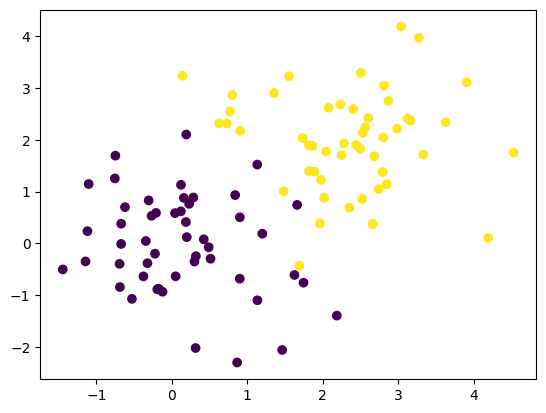

In [ ]:
# Geração de dados aleatórios
np.random.seed(1)
X1 = np.random.randn(50, 2)  # 50 amostras da classe 1
X2 = np.random.randn(50, 2) + 2  # 50 amostras da classe 2
X = np.concatenate((X1, X2))
Y = np.concatenate((np.zeros(50), np.ones(50))) # rótulos das classes (0 e 1)

# Visualizando as amostras (coloridas por classe)
plt.scatter(X[:,0],X[:,1],c=Y)
plt.show()

# Criando o modelo KNN
model = KNeighborsClassifier(n_neighbors=5)

# Treinando o modelo
model.fit(X, Y);

Em seguida, novas amostras aleatórias foram criadas para teste e o modelo foi utilizado para classificá-las.

A função *predict()* é utilizada para classificar as novas amostras.



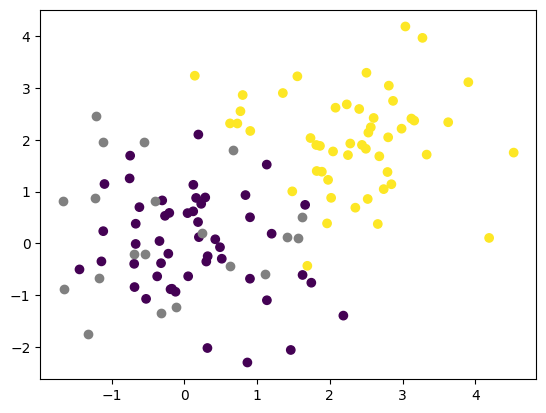

In [ ]:
# Criando novas amostras aleatórias para teste
X_test = np.random.randn(20, 2)

#  Visualizando o conjunto de teste
plt.scatter(X[:,0],X[:,1],c=Y)
plt.scatter(X_test[:,0],X_test[:,1],c='gray')
plt.show()

# Classificando as amostras
Y_test_pred = model.predict(X_test)

Para avaliar a qualidade de um classificador, normalmente se utiliza as seguintes métricas:

- [Acurácia (accuracy_score)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html): mede a proporção de amostras classificadas corretamente pelo modelo.
- [Precisão (precision_score)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html): mede a proporção de amostras classificadas como positivas (1) que são realmente positivas.
- [Recall (recall_score)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html): mede a proporção de amostras positivas (1) que são corretamente identificadas pelo modelo.
- [F1-Score (f1_score)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html): média harmônica entre precisão e recall.

Note que estas não são as únicas métricas utilizadas para avaliar um classificador. A escolha das métricas depende do contexto e dos objetivos da classificação. Na medicina, por exemplo, costuma-se utilizar a sensibilidade (ou recall) e a especificidade (mede a proporção de amostras negativas (0) que são corretamente identificadas pelo modelo). Dessa forma, pode-se determinar em que medida o classificador/exame é sensível à condição em questão (detecta corretamente as amostras positivas) e específico para detectar apenas ela (detecta corretamente as amostras negativas).

**Atenção**: para avaliar o modelo, as métricas foram calculadas em relação às amostras de treinamento, o que **não** é o ideal em um cenário real de classificação. No entanto, para fins didáticos, pode-se utilizar essas métricas para avaliar o desempenho do modelo.

In [ ]:
# Avaliando o modelo (as funções foram importadas previamente da biblioteca sklearn.metrics)
acc = accuracy_score(Y, model.predict(X))
prec = precision_score(Y, model.predict(X))
rec = recall_score(Y, model.predict(X))
f1 = f1_score(Y, model.predict(X))

# Imprimindo as métricas
print('Acurácia: %.2f' % acc)
print('Precisão: %.2f' % prec)
print('Recall: %.2f' % rec)
print('F1-Score: %.2f' % f1)

Acurácia: 0.96
Precisão: 0.94
Recall: 0.98
F1-Score: 0.96


Para fazer uma avaliação qualitativa do classificador, podemos plotar os resultados da classificação utilizando a função [scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) do matplotlib. As amostras de treinamento são plotadas com pontos circulares, enquanto as amostras de teste são plotadas com pontos cruzados.


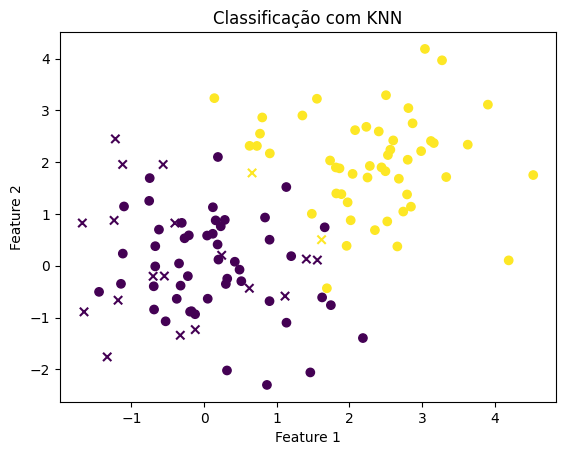

In [ ]:
# Plotando os resultados
plt.scatter(X[:, 0], X[:, 1], c=Y)
plt.scatter(X_test[:, 0], X_test[:, 1], marker='x', c=Y_test_pred)
plt.title('Classificação com KNN')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### Exercício 3.1

Vamos agora usar o mesmo classificador KNN para classificar imagens, utilizando um dataset de imagens dermatoscópicas de lesões de pele comuns.

**Dataset**

O dataset consiste em 500 imagens de lesões de pele, obtidas ao longo de 20 anos em dois hospitais diferentes. Como as imagens foram obtidas e armazenadas de diferentes formas ao longo do tempo (armazenadas em arquivos PowerPoint, por exemplo), elas passaram por um processo de seleção, organização e padronização para compor o dataset. Assim, as imagens foram cortadas em torno das lesões de modo a deixá-las centralizadas e, em alguns casos, tiveram seus histogramas corrigidos manualmente para melhorar o contraste visual e a reprodução de cores.

As imagens estão divididas em dois tipos de lesão de pele:
- 250 casos de carcinoma basocelular (label 0) - um tipo de câncer de pele que começa nas células basais, raramente apresenta metástase, mas cresce de forma destrutiva se não tratado;
- 250 casos de melanoma (label 1) - o tipo mais grave de câncer de pele, que começa nas células produtoras de melanina, é quase sempre curável em estágios iniciais, mas tende a apresentar metástase com o tempo.

**Classificação**

O dataset está separado em um conjunto de treino com 400 imagens (200 de cada classe) e um conjunto de teste com 100 imagens (50 de cada classe).

Neste caso, ao invés de utilizar dados aleatórios para treinamento e teste, vamos extrair os atributos dos histogramas dos conjuntos de imagens. Os atributos serão utilizadas como dados de entrada do modelo. As imagens devem ser classificadas em 0 ou 1, representando os dois tipos de lesões presentes no dataset (carcinoma ou melanoma, respectivamente).

O código abaixo cria os conjuntos de treino e teste (imagens e labels) utilizando as imagens disponíveis no dataset.

In [ ]:
path = f"gdrive/MyDrive/{pasta_compartilhada}/Dados/Ex02/Derma_MNIST_Dataset/"

images_train = []
labels_train = []
images_test = []
labels_test = []

list_dir = os.listdir(path)

for dir in list_dir:
  list_labels = os.listdir(os.path.join(path,dir))
  for l in list_labels:
    list_files = os.listdir(os.path.join(path,dir,l))
    for f in list_files:
      img = mpimg.imread(os.path.join(path,dir,l,f))
      if dir == 'train':
        images_train.append(img)
        labels_train.append(int(l))
      else:
        images_test.append(img)
        labels_test.append(int(l))

print(f'labels_train: \n{labels_train}')
print('Número de imagens de treino:', len(labels_train))

print(f'labels_test: \n{labels_test}')
print('Número de imagens de teste:', len(labels_test))

labels_train: 
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Agora, vamos visualizar algumas imagens do dataset. O código abaixo seleciona e plota quatro imagens aleatórias de cada classe do conjunto de treino. Tente executá-lo algumas vezes e comparar as duas classes visualmente.

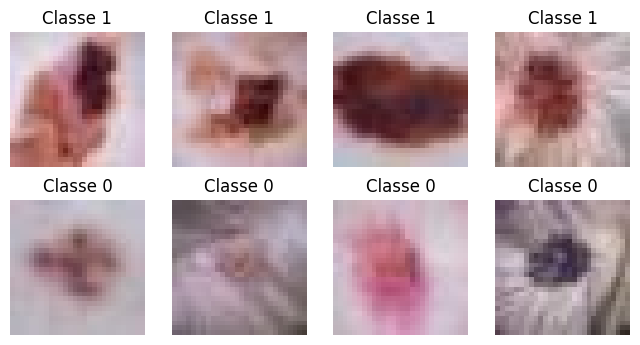

In [ ]:
images_train[random.randint(0,199)]
images_train[random.randint(200,399)]

n_imgs = 4
fig, axs = plt.subplots(2,n_imgs,figsize=(8, 4))

for n in range(n_imgs):
  plt.subplot(2,n_imgs,n+1)
  plt.axis('off')
  tmp = random.randint(0,199)
  plt.imshow(images_train[tmp])
  plt.title(f'Classe {labels_train[tmp]}')

  plt.subplot(2,n_imgs,n+n_imgs+1)
  plt.axis('off')
  tmp = random.randint(200,399)
  plt.imshow(images_train[tmp])
  plt.title(f'Classe {labels_train[tmp]}')

**a)** Crie uma função que receba um conjunto de imagens RGB, transforme as imagens em *grayscale*, e extraia os atributos do histograma de cada imagem. A função deve retornar os atributos dos histogramas concatenados em um vetor de atributos. Utilize a função **"histstat"** dada nesse notebook para extração de atributos.

Utilize os conjuntos de dados criados anteriormente para obter os vetores de atributos das amostras de treino e teste (train_features e test_features).

**Atenção!** Para o conjunto de treino você deve obter uma matriz 400 x 9, onde cada linha corresponde a uma amostra (imagem) e cada coluna correponde a um atributo do histograma. Da mesma forma, para o conjunto de teste você deve obter uma matriz 100 x 9.

In [ ]:
def classify(img_set, c = 'gray'):
  n
  my_set = np.array(img_set)
  if c == 'gray':
    my_set = rgb_to_gray(my_set[:])
    my_stats = np.array([histstat(img) for img in my_set])
  elif c == 'rgb':
    my_stats = {}
    my_stats['rgb'] = np.array([histstat(img) for img in my_set])
    for i, color in enumerate(c_rgb):
      my_stats[color] = np.array([histstat(img[:,:,i]) for img in my_set])
  return my_stats

train_features = classify(images_train)
test_features = classify(images_test)
print(train_features.shape)
print(test_features.shape)

(400, 9)
(100, 9)


**b)** Treine um modelo kNN utilizando o conjunto de dados de treino criado (train_features). Você precisará escolher um valor de k. Valide o modelo utilizando o conjunto de dados de teste (test_features). Calcule as métricas de avaliação do classificador para ambos os conjuntos de dados (primeiro para treino, depois para teste): acurácia, precisão, revocação e F1-score. Imprima a [Matriz de Confusão](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).


In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_features, labels_train)

labels_train_pred = model.predict(train_features)

labels_test_pred = model.predict(test_features)

Métricas do conjunto de treinamento
Acurácia: 0.79
Precisão: 0.81
Recall: 0.77
F1-Score 0.79



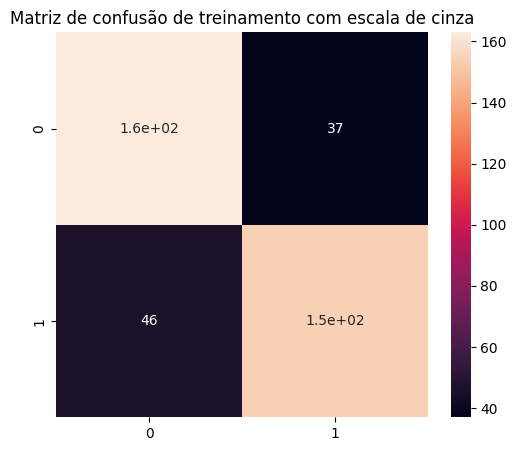

In [ ]:
# Avaliando o modelo (as funções foram importadas previamente da biblioteca sklearn.metrics)
acc = accuracy_score(labels_train, labels_train_pred)
prec = precision_score(labels_train, labels_train_pred)
rec = recall_score(labels_train, labels_train_pred)
f1 = f1_score(labels_train, labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train,labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com escala de cinza')
sn.heatmap(df_cm, annot=True);

Métricas do conjunto de teste com escala de cinza
Acurácia: 0.59
Precisão: 0.59
Recall: 0.58
F1-Score 0.59



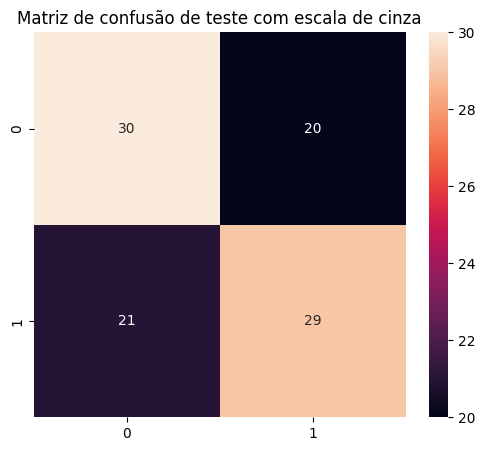

In [ ]:
acc = accuracy_score(labels_test, labels_test_pred)
prec = precision_score(labels_test, labels_test_pred)
rec = recall_score(labels_test, labels_test_pred)
f1 = f1_score(labels_test, labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com escala de cinza\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test,labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com escala de cinza')
sn.heatmap(df_cm, annot=True);

**c)** Tente plotar os resultados da classificação usando os atributos 2 a 2 como eixos (por exemplo, os valores de variância no eixo y e os valores de média no eixo x). Utilize a função [scatter()](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) do matplotlib, já demonstrada no início da Parte 3 deste notebook. As amostras de treinamento devem ser plotadas com pontos circulares, enquanto as amostras de teste devem ser plotadas com pontos cruzados. Comente os resultados obtidos.

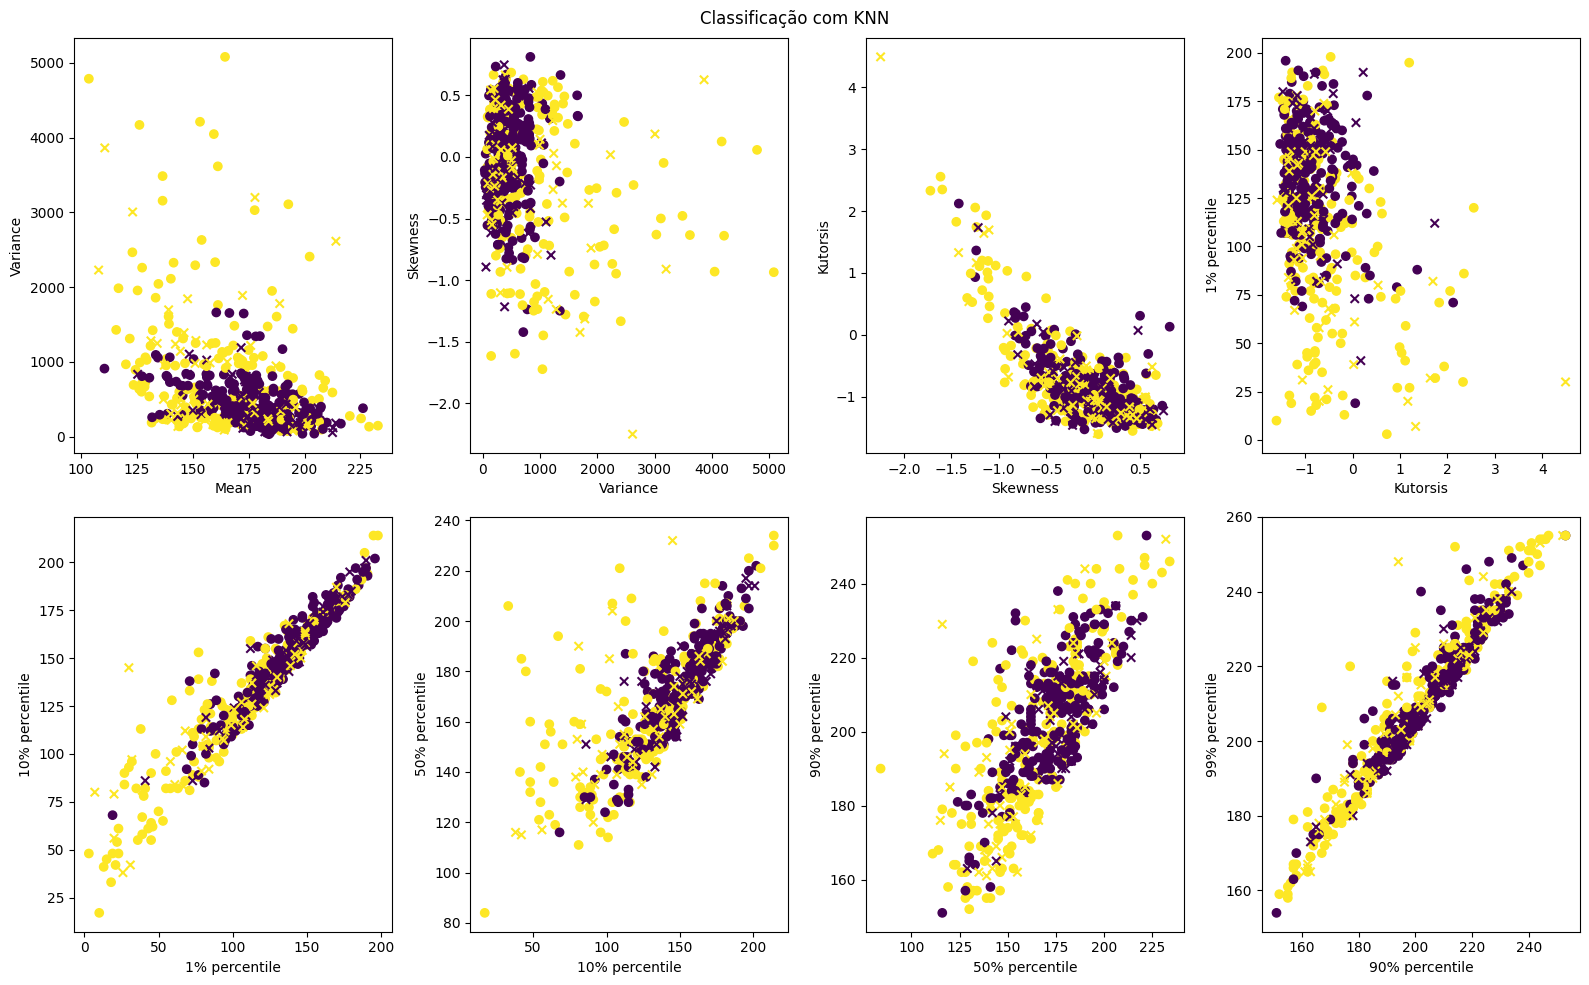

In [ ]:
# Plotando os resultados
fig, axs = plt.subplots(2,4,figsize=(16, 10))

stats_labels = ["Mean", "Variance", "Skewness", "Kutorsis", "1% percentile", "10% percentile", "50% percentile", "90% percentile", "99% percentile"]

for i in range(8):
  plt.subplot(2,4,i+1)
  plt.scatter(train_features[:, i], train_features[:, i+1], c = labels_train_pred)
  plt.scatter(test_features[:, i], test_features[:, i+1], marker='x', c = labels_test_pred)
  plt.xlabel(stats_labels[i])
  plt.ylabel(stats_labels[i+1])

plt.suptitle('Classificação com KNN')
plt.tight_layout()
plt.show()

**d)** Comente os resultados obtidos: Você está satisfeito com o resultado? O que você pode inferir do seu classificador ao observar as métricas obtidas? Qual o erro mais frequente? Quais modificações poderiam ser feitas para tentar obter melhores resultados?

Resposta: Os resultados não são satisfatórios pois só preveem metade dos casos conforme as métricas de avaliação.

### Exercício 3.2

Tente melhorar os resultados de classificação. Algumas sugestões:

- Redimensione as imagens para um tamanho menor **(14, 14)**, isso pode deixar os atributos menos suceptíveis a ruídos e detalhes, focando a classificação em características mais gerais;
- Altere o valor de vizinhos k;
- Em problemas de classificação, especialmente quando temos poucas amostras e muitos atributos, temos o "mal da dimensionalidade". A seleção de atributos pode ser utilizada para contornar esse problema e remover atributos reduntantes (correlacionados) ou irrelevantes. Você pode escolher atributos aleatoriamente, fazer uma análise estatística dos atributos correlacionados, ou ainda fazer uma análise visual. Pode também usar técnicas específicas de seleção de atributos ([feature selection](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection)).

In [ ]:
resized_train = [x[7:21,7:21,:] for x in images_train]
resized_test = [x[7:21,7:21,:] for x in images_test]

In [ ]:
# Classifcando os modelos redimensionados
resized_train_features = classify(resized_train)
resized_test_features = classify(resized_test)

# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(resized_train_features, labels_train)

# Predição do treinamento do modelo
resized_labels_train_pred = model.predict(resized_train_features)

# Predição do teste do modelo
resized_labels_test_pred = model.predict(resized_test_features)

Métricas do conjunto de treinamento com escala de cinza redimensionado
Acurácia: 0.81
Precisão: 0.80
Recall: 0.84
F1-Score 0.82



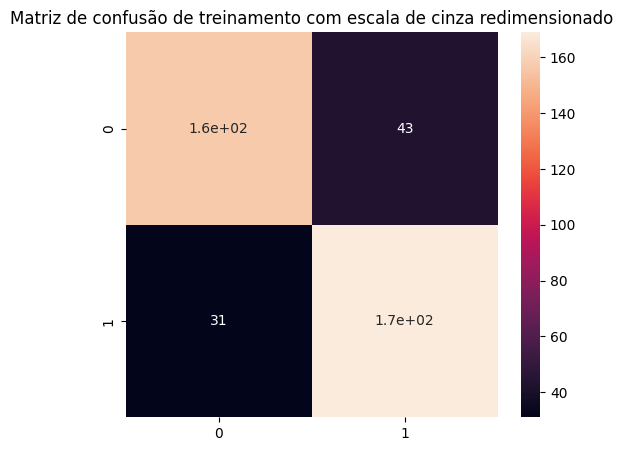

In [ ]:
# Métricas do modelos de treinamento
acc = accuracy_score(labels_train, resized_labels_train_pred)
prec = precision_score(labels_train, resized_labels_train_pred)
rec = recall_score(labels_train, resized_labels_train_pred)
f1 = f1_score(labels_train, resized_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento com escala de cinza redimensionado\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train, resized_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com escala de cinza redimensionado')
sn.heatmap(df_cm, annot=True);

Métricas do conjunto de teste com escala de cinza redimensionado
Acurácia: 0.80
Precisão: 0.77
Recall: 0.86
F1-Score 0.81



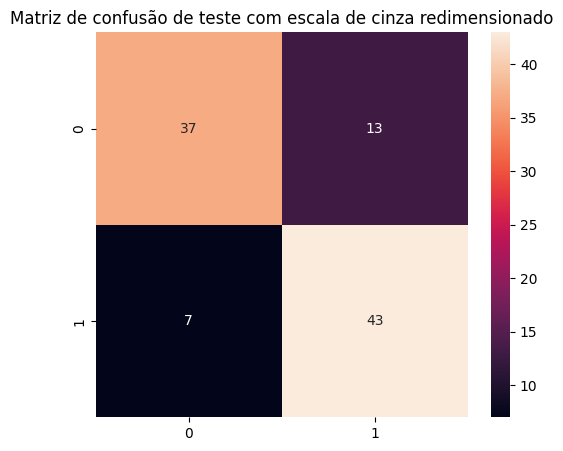

In [ ]:
# Métricas do conjunto de teste
acc = accuracy_score(labels_test, resized_labels_test_pred)
prec = precision_score(labels_test, resized_labels_test_pred)
rec = recall_score(labels_test, resized_labels_test_pred)
f1 = f1_score(labels_test, resized_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com escala de cinza redimensionado\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test, resized_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com escala de cinza redimensionado')
sn.heatmap(df_cm, annot=True);

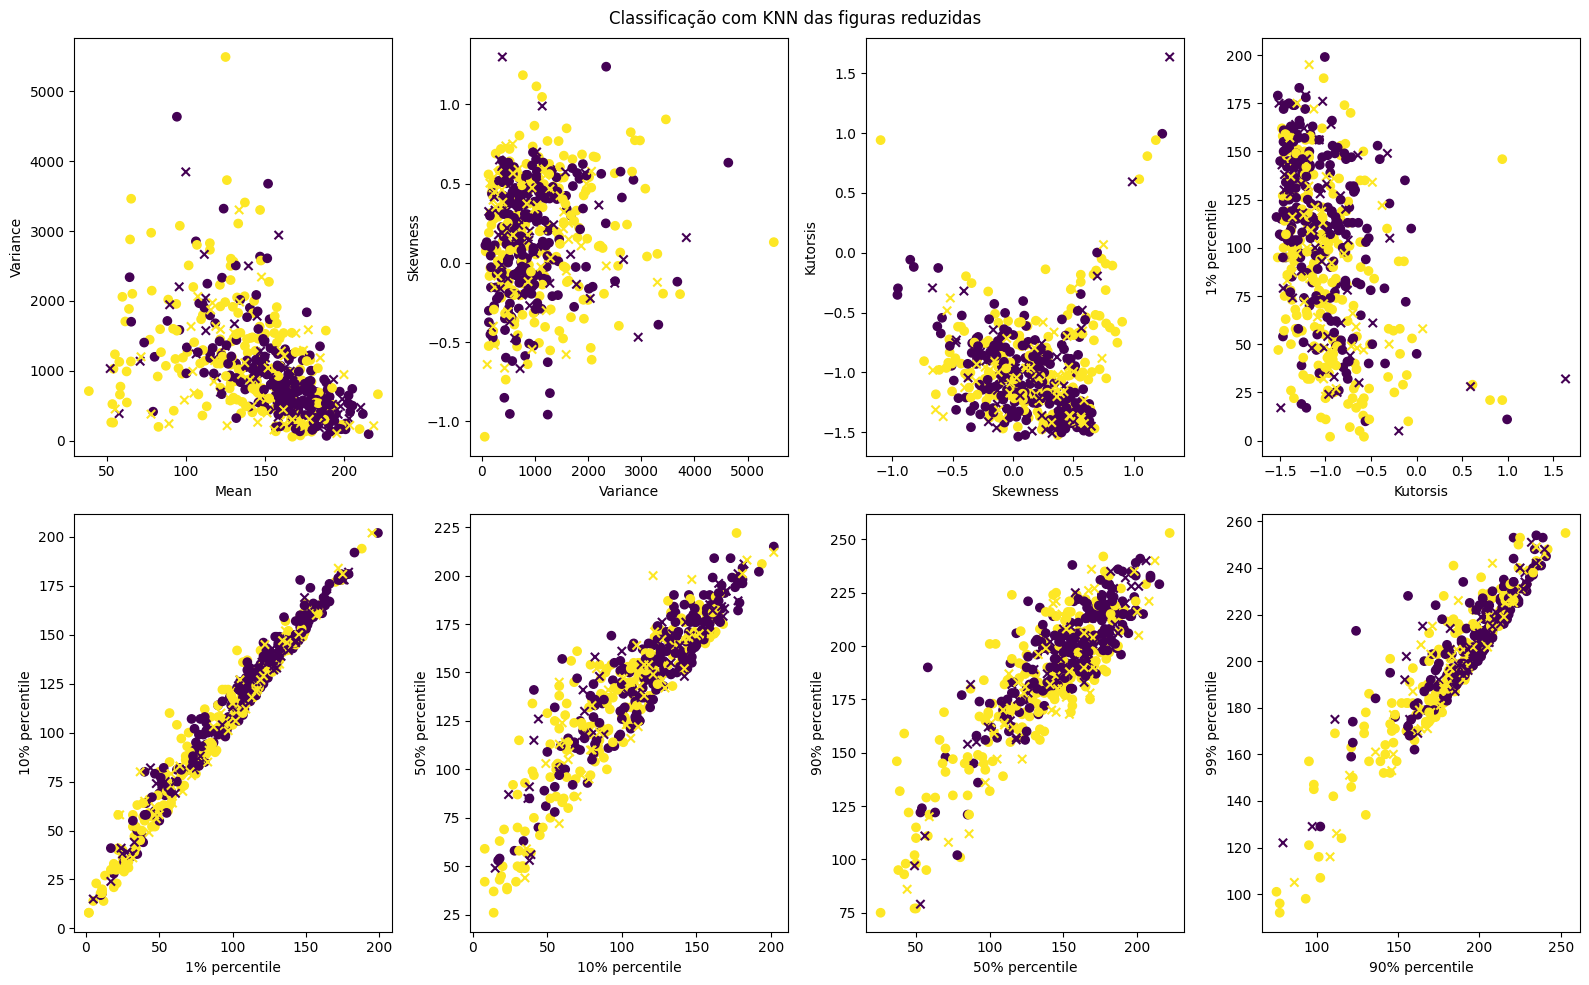

In [ ]:
# Plotando os resultados
fig, axs = plt.subplots(2,4,figsize=(16, 10))

stats_labels = ["Mean", "Variance", "Skewness", "Kutorsis", "1% percentile", "10% percentile", "50% percentile", "90% percentile", "99% percentile"]

for i in range(8):
  plt.subplot(2,4,i+1)
  plt.scatter(resized_train_features[:, i], resized_train_features[:, i+1], c = labels_train_pred)
  plt.scatter(resized_test_features[:, i], resized_test_features[:, i+1], marker='x', c = labels_test_pred)
  plt.xlabel(stats_labels[i])
  plt.ylabel(stats_labels[i+1])

plt.suptitle('Classificação com KNN das figuras reduzidas')
plt.tight_layout()
plt.show()

Reduzindo o tamanho da imagem utilizando slicing, ou seja, recortando para identificar um quadrado no centro da image de 14x14, obtemos um aumento de ~50% nas métricas.

## Parte 4 - Utilizando atributos de histograma de imagens coloridas (opicional para EA979)

Note que, ao realizar a transformação das imagens coloridas para imagens em escala de cinza na Parte 3 deste notebook, estamos desconsiderando características e informações das imagens com potencial para ajudar no processo de classificação.

### Exercício 4.1

Repita o processo de classificação do dataset de imagens dermatoscópicas, mas desta vez utilizando atributos de histograma extraídos diretamente das imagens coloridas (sem transformá-las para escala de cinza). Explique como a extração de atributos foi realizada e comente sobre os resultados obtidos. Lembre-se de tentar aplicar também as modificações utilizadas no exercício 3.2 para melhorar os resultados de classificação. Alguma das bandas da imagem se mostrou mais eficaz para a classificação? Os resultados de classificação foram melhores ou piores em relação a utilizar as imagens em escala de cinza? Comente.

In [ ]:
color_train = [x[7:21,7:21,:] for x in images_train]
color_test = [x[7:21,7:21,:] for x in images_test]

In [ ]:
  # Classifcando os modelos redimensionados sem transformar em escala de cinza
color_train_features = classify(color_train, c = 'rgb')
color_test_features = classify(color_test,  c = 'rgb')

# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(color_train_features['rgb'], labels_train)

# Treinamento do modelo
color_labels_train_pred = model.predict(color_train_features['rgb'])

# Predição do modelo
color_labels_test_pred = model.predict(color_test_features['rgb'])

Métricas do conjunto de treinamento com RGB
Acurácia: 0.86
Precisão: 0.86
Recall: 0.88
F1-Score 0.87



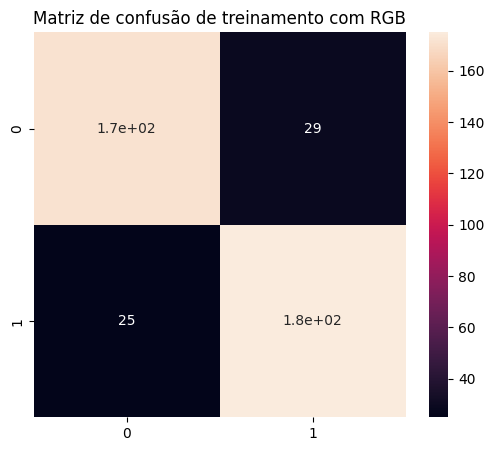

In [ ]:
# Métricas do modelos de treinamento
acc = accuracy_score(labels_train,  color_labels_train_pred)
prec = precision_score(labels_train, color_labels_train_pred)
rec = recall_score(labels_train, color_labels_train_pred)
f1 = f1_score(labels_train, color_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento com RGB\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train,color_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com RGB')
sn.heatmap(df_cm, annot=True)
plt.show();

Métricas do conjunto de teste com RGB
Acurácia: 0.80
Precisão: 0.79
Recall: 0.82
F1-Score 0.80



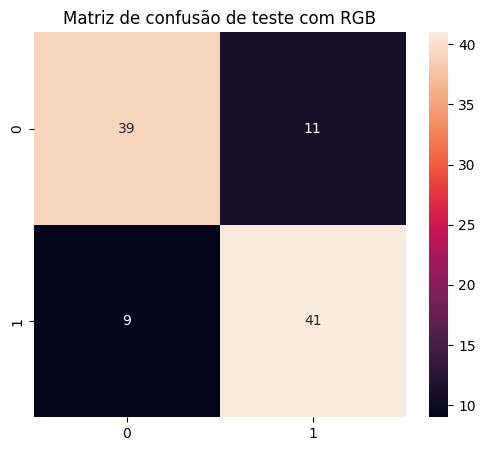

In [ ]:
# Métricas do conjunto de teste
acc = accuracy_score(labels_test, color_labels_test_pred)
prec = precision_score(labels_test, color_labels_test_pred)
rec = recall_score(labels_test, color_labels_test_pred)
f1 = f1_score(labels_test, color_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com RGB\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test,color_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com RGB')
sn.heatmap(df_cm, annot=True)
plt.show();

Métricas do conjunto de treinamento com R
Acurácia: 0.87
Precisão: 0.86
Recall: 0.89
F1-Score 0.87



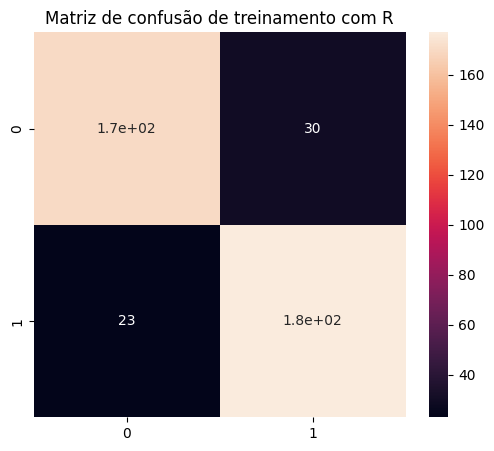

Métricas do conjunto de teste com R
Acurácia: 0.76
Precisão: 0.75
Recall: 0.78
F1-Score 0.76



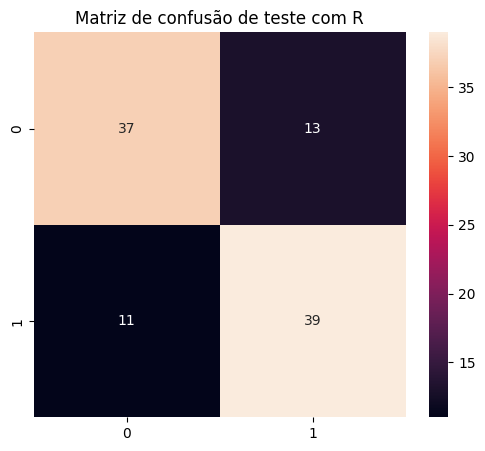

In [ ]:
  # Classifcando os modelos redimensionados sem transformar em escala de cinza
color_train_features = classify(color_train, c = 'rgb')
color_test_features = classify(color_test,  c = 'rgb')

# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(color_train_features['r'], labels_train)

# Treinamento do modelo
color_labels_train_pred = model.predict(color_train_features['r'])

# Predição do modelo
color_labels_test_pred = model.predict(color_test_features['r'])

# Métricas do modelos de treinamento
acc = accuracy_score(labels_train,  color_labels_train_pred)
prec = precision_score(labels_train, color_labels_train_pred)
rec = recall_score(labels_train, color_labels_train_pred)
f1 = f1_score(labels_train, color_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento com R\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train,color_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com R')
sn.heatmap(df_cm, annot=True)
plt.show();

# Métricas do conjunto de teste
acc = accuracy_score(labels_test, color_labels_test_pred)
prec = precision_score(labels_test, color_labels_test_pred)
rec = recall_score(labels_test, color_labels_test_pred)
f1 = f1_score(labels_test, color_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com R\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test,color_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com R')
sn.heatmap(df_cm, annot=True)
plt.show();

Métricas do conjunto de treinamento com G
Acurácia: 0.84
Precisão: 0.82
Recall: 0.87
F1-Score 0.85



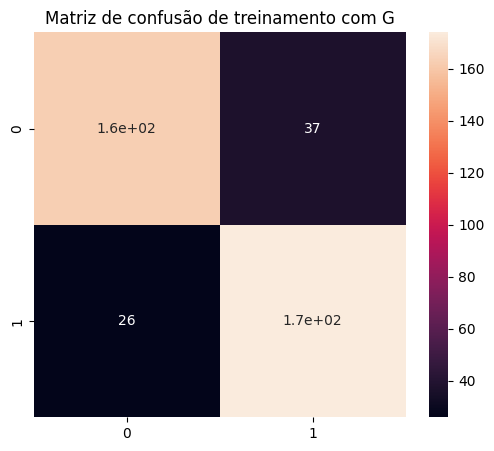

Métricas do conjunto de teste com G
Acurácia: 0.77
Precisão: 0.75
Recall: 0.82
F1-Score 0.78



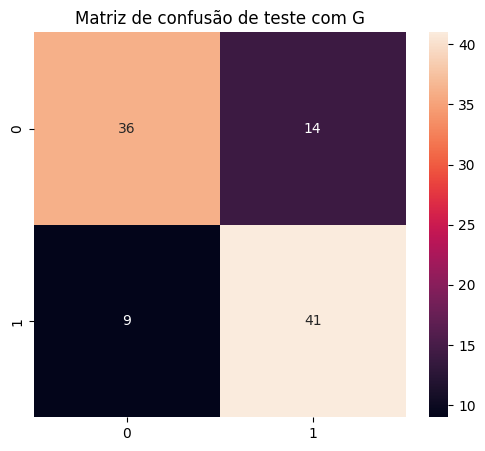

In [ ]:
  # Classifcando os modelos redimensionados sem transformar em escala de cinza
color_train_features = classify(color_train, c = 'rgb')
color_test_features = classify(color_test,  c = 'rgb')

# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(color_train_features['g'], labels_train)

# Treinamento do modelo
color_labels_train_pred = model.predict(color_train_features['g'])

# Predição do modelo
color_labels_test_pred = model.predict(color_test_features['g'])

# Métricas do modelos de treinamento
acc = accuracy_score(labels_train,  color_labels_train_pred)
prec = precision_score(labels_train, color_labels_train_pred)
rec = recall_score(labels_train, color_labels_train_pred)
f1 = f1_score(labels_train, color_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento com G\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train,color_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com G')
sn.heatmap(df_cm, annot=True)
plt.show();

# Métricas do conjunto de teste
acc = accuracy_score(labels_test, color_labels_test_pred)
prec = precision_score(labels_test, color_labels_test_pred)
rec = recall_score(labels_test, color_labels_test_pred)
f1 = f1_score(labels_test, color_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com G\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test,color_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com G')
sn.heatmap(df_cm, annot=True)
plt.show();

Métricas do conjunto de treinamento com B
Acurácia: 0.89
Precisão: 0.89
Recall: 0.90
F1-Score 0.89



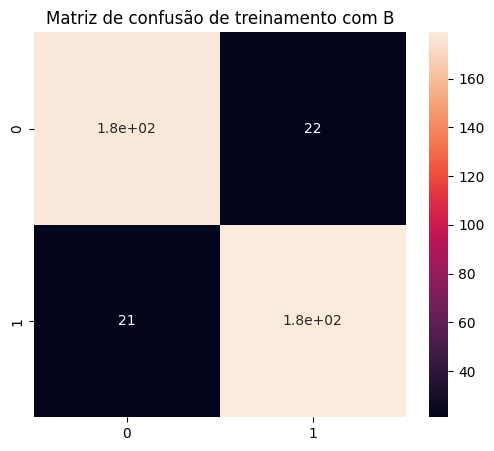

Métricas do conjunto de teste com B
Acurácia: 0.84
Precisão: 0.83
Recall: 0.86
F1-Score 0.84



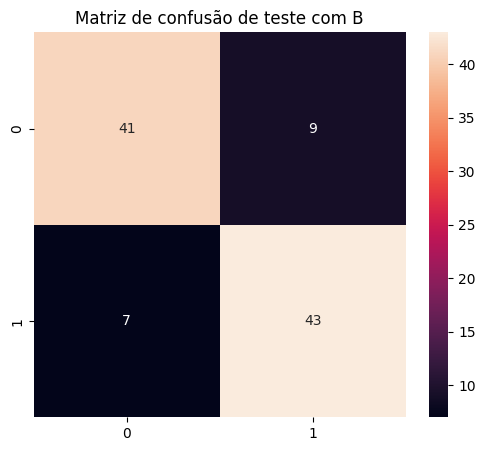

In [ ]:
  # Classifcando os modelos redimensionados sem transformar em escala de cinza
color_train_features = classify(color_train, c = 'rgb')
color_test_features = classify(color_test,  c = 'rgb')

# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(color_train_features['b'], labels_train)

# Treinamento do modelo
color_labels_train_pred = model.predict(color_train_features['b'])

# Predição do modelo
color_labels_test_pred = model.predict(color_test_features['b'])

# Métricas do modelos de treinamento
acc = accuracy_score(labels_train,  color_labels_train_pred)
prec = precision_score(labels_train, color_labels_train_pred)
rec = recall_score(labels_train, color_labels_train_pred)
f1 = f1_score(labels_train, color_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento com B\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train,color_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de treinamento com B')
sn.heatmap(df_cm, annot=True)
plt.show();

# Métricas do conjunto de teste
acc = accuracy_score(labels_test, color_labels_test_pred)
prec = precision_score(labels_test, color_labels_test_pred)
rec = recall_score(labels_test, color_labels_test_pred)
f1 = f1_score(labels_test, color_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste com B\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test,color_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
plt.title('Matriz de confusão de teste com B')
sn.heatmap(df_cm, annot=True)
plt.show();

**Resposta** O modelo utilizando o canal azul se mostrou melhor em classificar tanto no treino quanto em teste. Em escala de azul se mostrou muito mais eficaz em relaçao a escala de cinza com melhora de aproximadamente 4% na média das métricas

## Parte 5 - Explorando atributos de textura (opicional para EA979)

Além dos atributos de histograma, existem diversos outros tipos de atributos que podem ser extraídos de imagens digitais, como os atributos de textura, por exemplo. No processamento de imagens, a textura pode ser definida em função da variação espacial da intensidade dos pixels em uma região da imagem. Os atributos de textura são úteis para caracterizar padrões em uma imagem, como rugosidade, suavidade, granulosidade, entre outros. Assim, a análise de textura desempenha um papel importante em casos de visão computacional, como reconhecimento de objetos, detecção de defeitos de superfície, reconhecimento de padrões, análise de imagens médicas, etc.

**Para saber mais sobre atributos de textura, verifique os materiais de apoio disponibilizados no classroom.**

### Exercício 5.1

Extraia atributos de textura (como [GLCM](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html), por exemplo) e repita a classificação. Comente sobre o método de extração de atributos escolhido (como funciona? quais seus parâmetros? que atributos consegue extrair?) e os resultados obtidos.

In [ ]:
# Reutilizando as imagens
texture_train = [x[7:21,7:21,:] for x in images_train]
texture_test = [x[7:21,7:21,:] for x in images_test]



In [ ]:
def hist_n_texture_stat(f):

    h, bin_edges = np.histogram(f, 256, (0,255))
    hn = 1.0*h/h.sum() # compute the normalized image histogram
    cum_hn = np.cumsum(hn) # compute the cumulative image histogram
    v = np.zeros(11) # number of statistics
    glcm = graycomatrix(f, distances=[1], angles=[0], levels=256,
                  symmetric=True, normed=True)
    # compute statistics
    n = len(h) # number of values
    v[0]  = np.sum((np.arange(n)*hn)) # mean
    v[1]  = np.sum(np.power((np.arange(n)-v[0]),2)*hn) # variance
    v[2]  = np.sum(np.power((np.arange(n)-v[0]),3)*hn)/(np.power(v[1],1.5)) # skewness
    v[3]  = np.sum(np.power((np.arange(n)-v[0]),4)*hn)/(np.power(v[1],2))-3 # kurtosis
    v[4] = np.where(cum_hn >= 0.01)[0][0] # 1% percentile
    v[5] = np.where(cum_hn >= 0.1)[0][0] # 10% percentile
    v[6] = np.where(cum_hn >= 0.5)[0][0] # 50% percentile
    v[7] = np.where(cum_hn >= 0.9)[0][0] # 90% percentile
    v[8] = np.where(cum_hn >= 0.99)[0][0] # 99% percentile
    v[9] = graycoprops(glcm, 'dissimilarity')[0, 0]
    v[10] = graycoprops(glcm, 'correlation')[0, 0]

    return v

def classify_w_texture(img_set, c = 'gray'):
  n
  my_set = np.array(img_set)
  if c == 'gray':
    my_set = rgb_to_gray(my_set[:])
    my_stats = np.array([hist_n_texture_stat(img) for img in my_set])
  elif c == 'rgb':
    my_stats = {}
    my_stats['rgb'] = np.array([hist_n_texture_stat(img) for img in my_set])
    for i, color in enumerate(c_rgb):
      my_stats[color] = np.array([hist_n_texture_stat(img[:,:,i]) for img in my_set])
  return my_stats

texture_train_features = classify_w_texture(texture_train)
texture_test_features = classify_w_texture(texture_test)

In [ ]:
# Criação do modelo
model = KNeighborsClassifier(n_neighbors=3)

model.fit(texture_train_features, labels_train)

# Predição do treinamento do modelo
texture_labels_train_pred = model.predict(texture_train_features)

# Predição do teste do modelo
texture_labels_test_pred = model.predict(texture_test_features)

Métricas do conjunto de treinamento
Acurácia: 0.80
Precisão: 0.78
Recall: 0.83
F1-Score 0.81



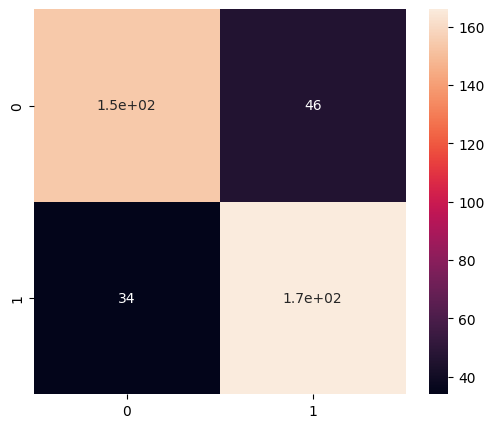

In [ ]:
# Métricas do modelos de treinamento
acc = accuracy_score(labels_train, texture_labels_train_pred)
prec = precision_score(labels_train, texture_labels_train_pred)
rec = recall_score(labels_train, texture_labels_train_pred)
f1 = f1_score(labels_train, texture_labels_train_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de treinamento\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_train, texture_labels_train_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
sn.heatmap(df_cm, annot=True);

Métricas do conjunto de teste
Acurácia: 0.83
Precisão: 0.80
Recall: 0.88
F1-Score 0.84



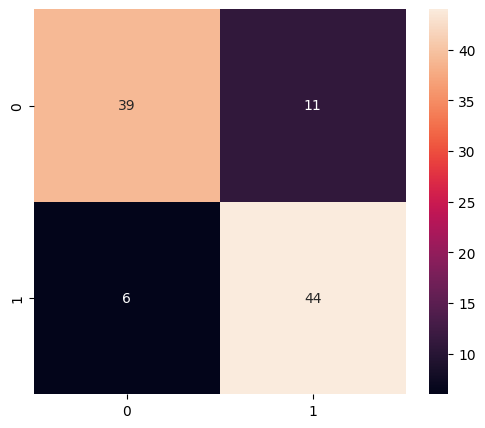

In [ ]:
# Métricas do conjunto de teste
acc = accuracy_score(labels_test, texture_labels_test_pred)
prec = precision_score(labels_test, texture_labels_test_pred)
rec = recall_score(labels_test, texture_labels_test_pred)
f1 = f1_score(labels_test, texture_labels_test_pred)

# Imprimindo as métricas
print(f"Métricas do conjunto de teste\nAcurácia: {acc:.2f}\nPrecisão: {prec:.2f}\nRecall: {rec:.2f}\nF1-Score {f1:.2f}\n")

# Matriz de confusão

cm = confusion_matrix(labels_test, texture_labels_test_pred)

df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                  columns = [i for i in "01"]);
plt.figure(figsize = (6,5));
sn.heatmap(df_cm, annot=True);

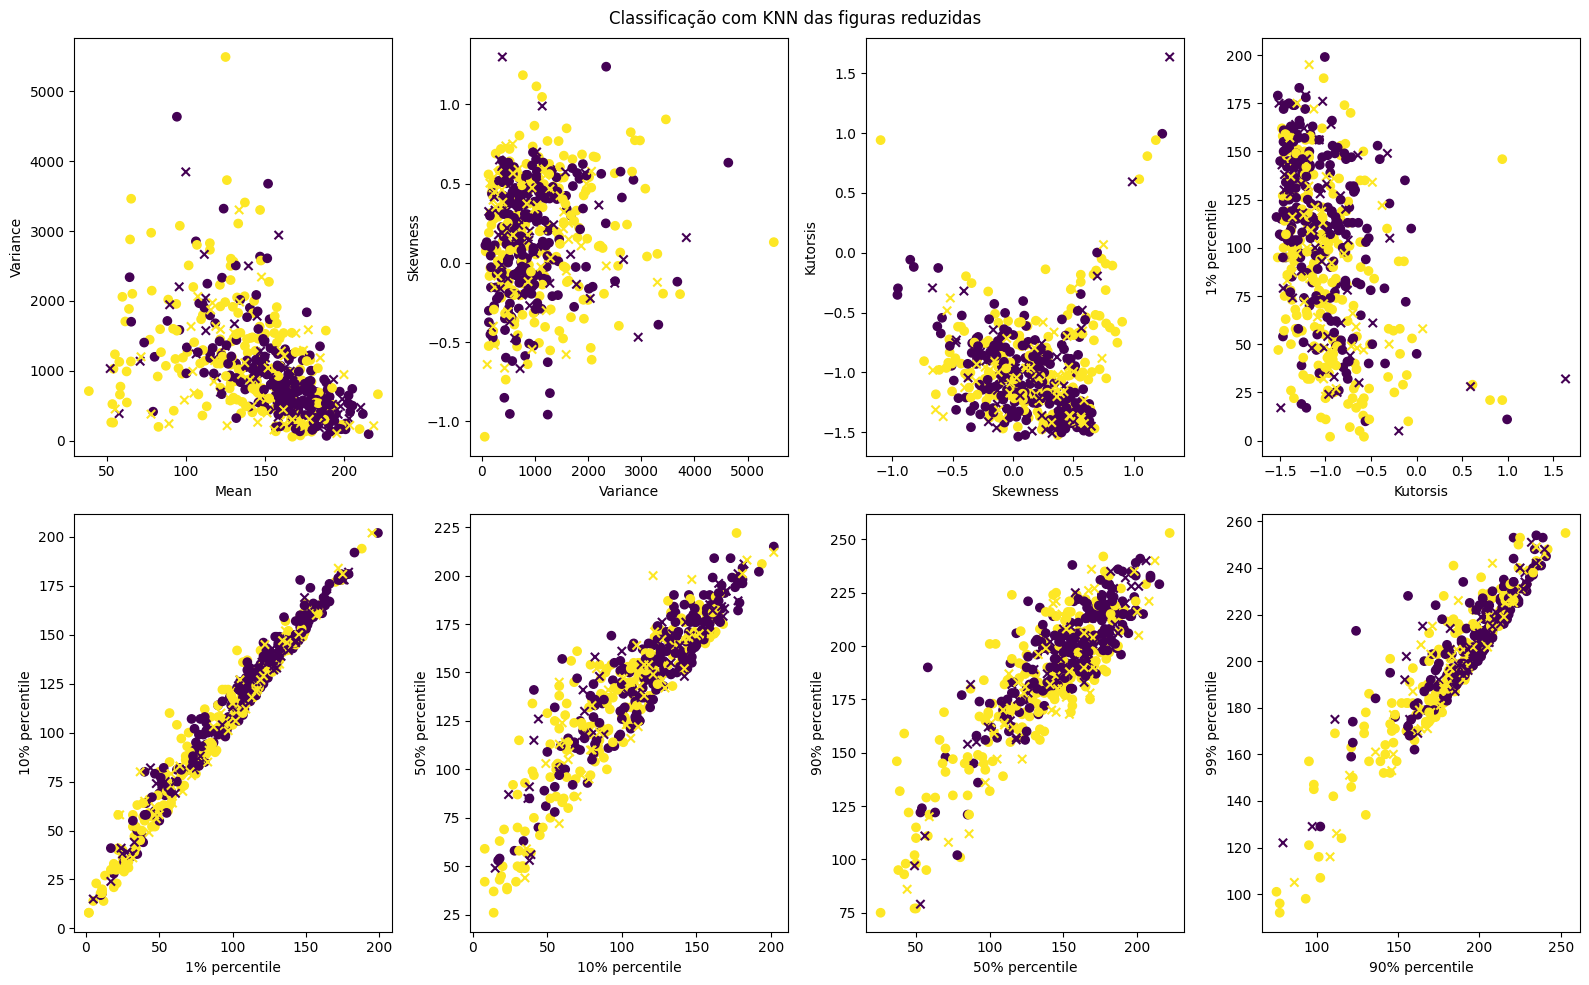

In [ ]:
# Plotando os resultados
fig, axs = plt.subplots(2,4,figsize=(16, 10))

stats_labels = ["Mean", "Variance", "Skewness", "Kutorsis", "1% percentile", "10% percentile", "50% percentile", "90% percentile", "99% percentile"]

for i in range(8):
  plt.subplot(2,4,i+1)
  plt.scatter(texture_train_features[:, i], texture_train_features[:, i+1], c = labels_train_pred)
  plt.scatter(texture_test_features[:, i], texture_test_features[:, i+1], marker='x', c = labels_test_pred)
  plt.xlabel(stats_labels[i])
  plt.ylabel(stats_labels[i+1])

plt.suptitle('Classificação com KNN das figuras reduzidas')
plt.tight_layout()
plt.show()

**Resposta** Os resultados comparados com apenas o modelo de escala cinza e redimensionado se mostraram melhores porém não significativamente melhores.

Da mesma forma se comparado com o melhor caso, utilizando apenas a escala de azul. Todos os modelos e as diferentes formas de classificação mostram uma melhoria significativa em relação ao modelo básico de escala cinza.

Desta forma podemos concluir que com uma seleção melhor dos atributos é possível aumentar a eficácia do classificador.